## Time series prediction

This is an example of how to do time series prediction with TensorFlow high level APIs. We'll use the weather dataset available at [big query](https://bigquery.cloud.google.com/dataset/bigquery-public-data:noaa_gsod) and can be generated with the following query:

```
SELECT year, mo, da, 
avg(temp) as avg_tmp, 
avg(dewp) as avg_dewp, 
avg(slp) as avg_slp
FROM `bigquery-public-data.noaa_gsod.gsod*`
WHERE temp <> 9999.9 and dewp <> 9999.9 and slp <> 9999.9
GROUP BY year, mo, da
ORDER BY year asc, mo asc, da asc
```

You can download the data from [here](https://drive.google.com/file/d/0B5o0xAAYXFw2V1M2NDBUeHV4bEU/view?usp=sharing).

We'll implement a RNN model using the Estimators API that given the average temperature of 10 days can predict the average temperature of the following day (11th).


## Dependecies

In [3]:
# tensorflow
import tensorflow as tf

# rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# helpers
import numpy as np
import pandas as pd
import csv

# enable tensorflow logs
tf.logging.set_verbosity(tf.logging.INFO)

## Preparing the data

First let's prepare the data for the model, the expected input for a RNN is:

* x = sequence of features
* y = what we want to predict/classify from x, in our case we want to predict the next avg temperature


In [5]:
df = pd.read_csv('weather.csv')

number_of_rows = len(df)
print('number of rows in the dataset:', number_of_rows)

print('how a row looks like:')
print(df.head(11))

print()
print("we don't use the year mo da columns, so let's forget about them")
df = df[['avg_tmp', 'avg_dewp', 'avg_slp']]
print(df.head(11))

number of rows in the dataset: 32094
how a row looks like:
    year  mo  da  avg_tmp  avg_dewp   avg_slp
0   1929   8   1   58.200    52.875   994.950
1   1929   8   2   55.925    49.500  1013.075
2   1929   8   3   56.650    51.350  1013.675
3   1929   8   4   60.625    55.350  1004.625
4   1929   8   5   58.450    48.300  1010.400
5   1929   8   6   58.700    56.525  1008.000
6   1929   8   7   58.525    54.975  1007.825
7   1929   8   8   58.200    49.925  1015.800
8   1929   8   9   58.850    52.150  1016.400
9   1929   8  10   62.225    56.175  1018.250
10  1929   8  11   62.975    57.900  1017.550

we don't use the year mo da columns, so let's forget about them
    avg_tmp  avg_dewp   avg_slp
0    58.200    52.875   994.950
1    55.925    49.500  1013.075
2    56.650    51.350  1013.675
3    60.625    55.350  1004.625
4    58.450    48.300  1010.400
5    58.700    56.525  1008.000
6    58.525    54.975  1007.825
7    58.200    49.925  1015.800
8    58.850    52.150  1016.400
9   

In [7]:
SEQ_LEN = 10
VALID_ROWS = number_of_rows - SEQ_LEN - 1
NUM_FEATURES = 3

# then we can use indexes to access rows easily
df = np.asarray(df)

# sequences will have shape: [VALID_ROWS, SEQ_LEN, NUM_FEATURES]
sequences = np.zeros((VALID_ROWS, SEQ_LEN, NUM_FEATURES), dtype=np.float32)
labels = np.zeros((VALID_ROWS, 1))

# sequences are 10 days
# label is the avg_tmp for the following day (11th)
for i in range(VALID_ROWS):
    sequences[i] = df[i: i + SEQ_LEN]
    labels[i] = df[i + SEQ_LEN][0]

print('-' * 20)
print('Example')
print('-' * 20)

print('sequence:')
print(sequences[0])
print('prediction:', labels[0])

--------------------
Example
--------------------
sequence:
[[   58.20000076    52.875        994.95001221]
 [   55.92499924    49.5         1013.07501221]
 [   56.65000153    51.34999847  1013.67498779]
 [   60.625         55.34999847  1004.625     ]
 [   58.45000076    48.29999924  1010.40002441]
 [   58.70000076    56.52500153  1008.        ]
 [   58.52500153    54.97499847  1007.82501221]
 [   58.20000076    49.92499924  1015.79998779]
 [   58.84999847    52.15000153  1016.40002441]
 [   62.22499847    56.17499924  1018.25      ]]
prediction: [ 62.975]


### Separating training, evaluation and a small test data

The test data is going to be very small (10 sequences) and is being used just for visualization.

In [13]:
# these values are based on the number of valid rows which is 32083
TRAIN_SIZE = 30000
EVAL_SIZE = 2073
TEST_SIZE = 10

# shuffle the data
assert len(sequences) == len(labels)
p = np.random.permutation(len(sequences))
sequences = sequences[p]
labels = labels[p]

train_seq = sequences[:TRAIN_SIZE]
train_label = np.asarray(labels[:TRAIN_SIZE], dtype=np.float32)

eval_seq = sequences[TRAIN_SIZE: TRAIN_SIZE + EVAL_SIZE]
eval_label = np.asarray(labels[TRAIN_SIZE:TRAIN_SIZE + EVAL_SIZE], dtype=np.float32)

test_seq = sequences[TRAIN_SIZE + EVAL_SIZE: ]
test_label = np.asarray(labels[TRAIN_SIZE + EVAL_SIZE: ], dtype=np.float32)

print('train shape:', train_seq.shape)
print('eval shape:', eval_seq.shape)
print('test shape:', test_seq.shape)

train shape: (30000, 10, 3)
eval shape: (2073, 10, 3)
test shape: (10, 10, 3)


### What we want to predict

This is the plot of the labels from the test data.

/usr/local/lib/python3.4/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


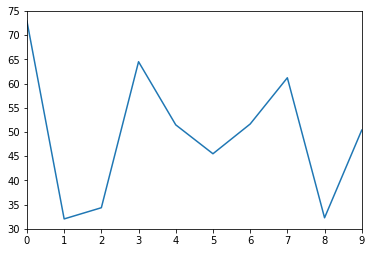

In [14]:
# getting test labels
test_plot_data = [test_label[i][0] for i in range(TEST_SIZE)]

# plotting
sns.tsplot(test_plot_data)
plt.show()

## Defining Input functions

In [15]:
BATCH_SIZE = 64

FEATURE_KEY = 'x'
SEQ_LEN_KEY = 'sequence_length'
def make_dict(x):
    d = {}
    d[FEATURE_KEY] = x
    # [SIZE OF DATA SET, 1]
    # where the second dimesion contains the sequence of each
    # sequence in the data set
    d[SEQ_LEN_KEY] = np.asarray(x.shape[0] * [SEQ_LEN], dtype=np.int32)
    return d

# Make input function for training: 
#   num_epochs=None -> will cycle through input data forever
#   shuffle=True -> randomize order of input data
train_input_fn = tf.estimator.inputs.numpy_input_fn(x=make_dict(train_seq),
                                                    y=train_label,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    num_epochs=None)

# Make input function for evaluation:
# shuffle=False -> do not randomize input data
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x=make_dict(eval_seq),
                                                    y=eval_label,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False)

# Make input function for testing:
# shuffle=False -> do not randomize input data
test_input_fn = tf.estimator.inputs.numpy_input_fn(x=make_dict(test_seq),
                                                    y=test_label,
                                                    batch_size=1,
                                                    shuffle=False)

### RNN Model

In [16]:
N_OUTPUTS = 1 # 1 prediction
NUM_FEATURES = 3

def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode, params):

        x = features[FEATURE_KEY]
        sequence_length = features[SEQ_LEN_KEY]

        # 1. configure the RNN
        
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        
        outputs, _ = tf.nn.dynamic_rnn(multi_rnn_cell, x, dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(last_activations,
                                               units,
                                               activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)
        
        # 2. Define the loss function for training/evaluation
        loss = None
        eval_metric_ops = None
        train_op = None

        # if predicting labels can be None
        if mode != tf.estimator.ModeKeys.PREDICT:
            loss = tf.losses.mean_squared_error(labels, predictions)
            eval_metric_ops = {
              "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
            }

            # 3. Define the training operation/optimizer
            train_op = tf.contrib.layers.optimize_loss(
              loss=loss,
              global_step=tf.contrib.framework.get_global_step(),
              learning_rate=learning_rate,
              optimizer=optimizer)

        # 4. Create predictions
        predictions_dict = {"predicted": predictions}

        # 5. return ModelFnOps
        return tf.estimator.EstimatorSpec(
          mode=mode,
          predictions=predictions_dict,
          loss=loss,
          train_op=train_op,
          eval_metric_ops=eval_metric_ops)
    
    return model_fn

## Running model

In [17]:
model_fn = get_model_fn(rnn_cell_sizes=[64], # size of the hidden layers
                        label_dimension=1, # since is just 1 prediction
                        dnn_layer_sizes=[32], # size of units in the dense layers on top of the RNN
                        optimizer='Adam',
                        learning_rate=0.001)

estimator = tf.estimator.Estimator(model_fn=model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_model_dir': '/tmp/tmp4qxiu_d5', '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_tf_random_seed': 1, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


### Trainning

In [18]:
estimator.train(input_fn=train_input_fn, steps=10000)

Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Please switch to tf.train.assert_global_step
INFO:tensorflow:Create CheckpointSaverHook.


/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp4qxiu_d5/model.ckpt.
INFO:tensorflow:step = 1, loss = 2918.31
INFO:tensorflow:global_step/sec: 158.482
INFO:tensorflow:step = 101, loss = 1835.27 (0.632 sec)
INFO:tensorflow:global_step/sec: 188.274
INFO:tensorflow:step = 201, loss = 693.025 (0.531 sec)
INFO:tensorflow:global_step/sec: 211.844
INFO:tensorflow:step = 301, loss = 171.843 (0.472 sec)
INFO:tensorflow:global_step/sec: 216.231
INFO:tensorflow:step = 401, loss = 169.523 (0.463 sec)
INFO:tensorflow:global_step/sec: 212.212
INFO:tensorflow:step = 501, loss = 173.152 (0.471 sec)
INFO:tensorflow:global_step/sec: 205.531
INFO:tensorflow:step = 601, loss = 162.311 (0.487 sec)
INFO:tensorflow:global_step/sec: 215.288
INFO:tensorflow:step = 701, loss = 94.2222 (0.464 sec)
INFO:tensorflow:global_step/sec: 213.273
INFO:tensorflow:step = 801, loss = 75.7156 (0.469 sec)
INFO:tensorflow:global_step/sec: 202.654
INFO:tensorflow:step = 901, loss = 69.1147 (0.494 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 220.308
INFO:tensorflow:step = 8501, loss = 1.23549 (0.454 sec)
INFO:tensorflow:global_step/sec: 218.716
INFO:tensorflow:step = 8601, loss = 1.12603 (0.457 sec)
INFO:tensorflow:global_step/sec: 218.121
INFO:tensorflow:step = 8701, loss = 2.57851 (0.458 sec)
INFO:tensorflow:global_step/sec: 222.021
INFO:tensorflow:step = 8801, loss = 1.73448 (0.450 sec)
INFO:tensorflow:global_step/sec: 221.947
INFO:tensorflow:step = 8901, loss = 2.94743 (0.451 sec)
INFO:tensorflow:global_step/sec: 219.231
INFO:tensorflow:step = 9001, loss = 1.74201 (0.456 sec)
INFO:tensorflow:global_step/sec: 223.072
INFO:tensorflow:step = 9101, loss = 1.29478 (0.448 sec)
INFO:tensorflow:global_step/sec: 217.821
INFO:tensorflow:step = 9201, loss = 2.55973 (0.459 sec)
INFO:tensorflow:global_step/sec: 224.078
INFO:tensorflow:step = 9301, loss = 1.68545 (0.446 sec)
INFO:tensorflow:global_step/sec: 223.501
INFO:tensorflow:step = 9401, loss = 2.18164 (0.447 sec)
INFO:tensorflow:global_step/se

### Evaluating

In [19]:
ev = estimator.evaluate(input_fn=eval_input_fn)
print(ev)

Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Please switch to tf.train.assert_global_step
INFO:tensorflow:Starting evaluation at 2017-08-15-14:02:44


/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from /tmp/tmp4qxiu_d5/model.ckpt-10000
INFO:tensorflow:Finished evaluation at 2017-08-15-14:02:45
INFO:tensorflow:Saving dict for global step 10000: global_step = 10000, loss = 1.65529, rmse = 1.28595
{'rmse': 1.2859511, 'global_step': 10000, 'loss': 1.6552891}


### Testing

In [20]:
preds = list(estimator.predict(input_fn=test_input_fn))
predictions = []
for p in preds:
    print(p)
    predictions.append(p["predicted"][0])

INFO:tensorflow:Restoring parameters from /tmp/tmp4qxiu_d5/model.ckpt-10000
{'predicted': array([ 71.16423035], dtype=float32)}
{'predicted': array([ 33.20519257], dtype=float32)}
{'predicted': array([ 34.46249008], dtype=float32)}
{'predicted': array([ 64.84555054], dtype=float32)}
{'predicted': array([ 51.94036484], dtype=float32)}
{'predicted': array([ 44.14349365], dtype=float32)}
{'predicted': array([ 50.87601852], dtype=float32)}
{'predicted': array([ 60.52082825], dtype=float32)}
{'predicted': array([ 33.25720215], dtype=float32)}
{'predicted': array([ 51.82673645], dtype=float32)}


### Visualizing predictions

/usr/local/lib/python3.4/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


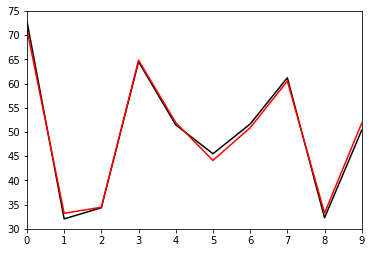

In [21]:
# plotting real values in black
sns.tsplot(test_plot_data, color="black")
# plotting predictions in red
sns.tsplot(predictions, color="red")

plt.show()